In [1]:
import os

fname = "Data/jena_climate_2009_2016.csv"

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

#print(header)
print("#Features:",len(header))
for i, feature in enumerate(header):
    print(i,feature)

print("")
print("#Number of Samples:",len(lines))
print("")
print("Sample_0:")
print(lines[0])
print(type(lines[0]))

#Features: 15
0 "Date Time"
1 "p (mbar)"
2 "T (degC)"
3 "Tpot (K)"
4 "Tdew (degC)"
5 "rh (%)"
6 "VPmax (mbar)"
7 "VPact (mbar)"
8 "VPdef (mbar)"
9 "sh (g/kg)"
10 "H2OC (mmol/mol)"
11 "rho (g/m**3)"
12 "wv (m/s)"
13 "max. wv (m/s)"
14 "wd (deg)"

#Number of Samples: 420551

Sample_0:
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
<class 'str'>


In [26]:
import numpy as np
float_data = np.zeros((len(lines),len(header)-1))
print(float_data.shape)

#strint-to-float data transformation while dropping the datetime
#droppint the datetime is not a problem, cause the timestamps are each 10 min apart
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i, :] = values
    
print("We have 420551 samples (points in time) with 14 features each")    
print(float_data.shape)

(420551, 14)
We have 420551 samples (points in time) with 14 features each
(420551, 14)


In [3]:
print(float_data[0])

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


In [4]:
import matplotlib.pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)), temp)

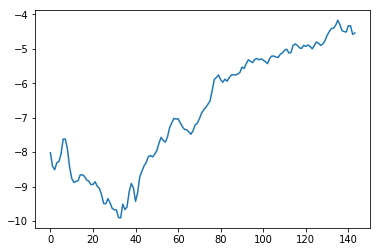

In [5]:
plt.plot(range(144), temp[:144])

In [6]:
#normalize data based on the first 200000 Samples (Split in Train & Val)
mean = float_data[:200000].mean(axis = 0)
std = float_data[:200000].std(axis = 0)
print(mean.shape,std.shape)
float_data -= mean
float_data /= std
print(float_data[0])

(14,) (14,)
[ 0.90014748 -1.93135845 -1.98211036 -1.86280029  1.07285236 -1.30742164
 -1.47375773 -0.79868641 -1.4762674  -1.47815522  2.12375056 -0.72950452
 -0.78067973 -0.27613603]


In [31]:
lookback = 720 #5 days in the past
step = 6 #one sample per hour
delay = 144 #target 24h in the future
batch_size = 128

def generator(
    data,           # our timeseries
    lookback, 
    delay,
    min_index, 
    max_index,
    shuffle=False,
    step=6,
    batch_size=128):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    
    verbose = True 
    
    while True:

       
        
        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index,
                batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        if verbose:
            print(rows)
            
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

            print("j:",j,"row:", row,"Idx:",indices)
            
        verbose = False
        
        yield samples, targets

In [32]:
g = generator(float_data, lookback, delay, 0, 200000, True)
#output type of next(g) is <class 'tuple'>
print(next(g))

[ 75543 149823  51388 111353 101350  65292  40085  67044  75210  88915
  25474 104039 153390 155358  91127 160970 112475  52368  10976 164425
 115122  87386 163824  77635  89123  25776 116604 194475  23371  69625
 115533  71257  90111 182591 144399  88250  68831  47849  30106  97354
 100749 193294 128355 163935 178609  14134 185516 105495  14762  47162
  94302 153862 184011  30255  65317 162225 163422 113485  86168  60115
 151887 174928 101058  32771 156071  16835  40686  36547  85298 128550
  59665 123579 115604 161036 160188 185193 159752 197193 166146 180713
  69562 175434  13799  70233 127668  83107  89429  11163  17948 144419
  79003 135537 116991  89179  76074  25653 134067 104592 116340  47359
  81644 198363 173847  29346 119650  37567  89262  86254 189987  21657
  86009 190655 170547  10100 166122 164438 180559  59638  32065 141087
 179926  73595  53206   1695 145513  61049 114354 114050]
j: 0 row: 75543 Idx: range(74823, 75543, 6)
j: 1 row: 149823 Idx: range(149103, 149823, 6)

In [9]:
lookback = 1440 #10 days in the past
step = 6 #one sample per hour
delay = 144 #target 24h in the future
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [22]:
t = next(g)

In [25]:
print("Len:",len(t))
print(t[0].shape)
print(t[1].shape)
print(t[0])
print(t[1])

Len: 2
(128, 120, 14)
(128,)
[-0.62325326  0.72099991 -1.04008471  1.24288644 -1.39478681 -1.42980517
 -1.30893535 -2.8090767   0.26124273  0.98533205 -0.45606884 -0.41427273
  0.53235262 -0.38377287 -0.80964131  1.6326069   1.59871816 -0.353273
  0.87575847 -0.68086411  1.17623859 -1.17225078 -0.76445633  0.73455541
  0.84412898  0.13811366  0.92885082 -1.99574705 -1.01862185 -0.0166449
  1.30388616  1.25757156 -0.80964131 -0.12621848  1.1536461  -0.87741878
  0.27027973  0.30981659 -0.06182988 -0.82658568 -0.40975423 -0.97569611
 -1.23550975 -0.13864435  0.4442419  -1.64895233 -0.68199374 -2.10532063
  1.56257018 -1.55180462 -1.73367416  0.83283274  0.83735124  0.08953981
  1.21464582 -0.74412309 -1.90876596  0.53461187 -0.50916119  0.36064969
 -0.59388303 -0.65827162  0.07824356  1.00566529 -0.81415981 -0.78817844
  0.22057625 -1.75174816 -0.63003101 -1.17225078 -1.04460321 -0.30469915
  0.06694732  0.36516819 -0.4730132   1.34116377 -0.59501265 -0.48092058
 -1.4173793  -0.1318666  

In [10]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Flatten(
    input_shape = (lookback // step, float_data.shape[-1])
))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

model.summary()

model.compile(
    optimizer = optimizers.RMSprop(),
    loss="mse",
    metrics=["mae"]
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = 500,
    epochs = 20,
    validation_data = val_gen,
    validation_steps = val_steps // 100
)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 3.9350 - mean_absolute_error: 1.1192 - val_loss: 0.2897 - val_mean_absolute_error: 0.4246
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.6965 - mean_absolute_error: 0.5864 - val_loss: 0.1741 - val_mean_absolute_error: 0.3262
Epoch 3/20
500/500 [==============================] - 12s 25ms/step 

Different layer tpyes: GRU (gated rectified unit)

In [33]:
float_data.shape

(420551, 14)

In [11]:
model = models.Sequential()
model.add(layers.GRU(
    32, input_shape = (None, float_data.shape[-1]) # --> (None, 14)
))
model.add(layers.Dense(1))

model.summary()

model.compile(
    optimizer = optimizers.RMSprop(),
    loss="mse",
    metrics=["mae"]
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = 500,
    epochs = 20,
    validation_data = val_gen,
    validation_steps = val_steps // 100
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 58s 116ms/step - loss: 0.1527 - mean_absolute_error: 0.3032 - val_loss: 0.1264 - val_mean_absolute_error: 0.2777
Epoch 2/20
500/500 [==============================] - 58s 116ms/step - loss: 0.1325 - mean_absolute_error: 0.2839 - val_loss: 0.1123 - val_mean_absolute_error: 0.2610
Epoch 3/20
500/500 [==============================] - 57s 115ms/step - loss: 0.1256 - mean_absolute_error: 0.2774 - val_loss: 0.1149 - val_mean_absolute_error: 0.2605
Epoch 4/20
500/500 [===============